In [9]:
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from matplotlib import pyplot as plt
import time
from copy import deepcopy

In [12]:
sigma = np.array([0.25, 0.35])
na = len(sigma)
correl = 0.5

K = 1

In [13]:
T = 1
n = 365

p_uu = p_dd = (1 + correl) / 4
p_ud = p_du = (1 - correl) / 4

In [14]:
def compute_S(num_nodes_total: int, num_nodes: int, sigma: np.array, T_total: float):
    dt = T_total / num_nodes_total
    step_sizes = sigma * dt**0.5
    X = np.array([step_sizes[0] * (2 * np.arange(num_nodes+1) - num_nodes).reshape(num_nodes+1, -1).repeat(num_nodes+1, 1),
                  step_sizes[1] * (2 * np.arange(num_nodes+1) - num_nodes).reshape(-1, num_nodes+1).repeat(num_nodes+1, 0)])
    S = np.exp(X)
    S[0] = S[0] * np.exp(-0.5 * sigma[0]**2 * num_nodes * dt)
    S[1] = S[1] * np.exp(-0.5 * sigma[1]**2 * num_nodes * dt)
    return S

In [15]:
def simulate_S(Ts, num_sim, seed=2023):
    np.random.seed(seed=seed)
    dTs = np.diff(Ts, n=1, prepend=[0])
    S = np.zeros((len(Ts), num_sim, na))
    for i in range(len(Ts)):
        X0 = np.random.normal(size=num_sim)
        X1 = correl * X0 + (1-correl**2)**0.5 * np.random.normal(size=num_sim)
        S[i, :, 0] = np.exp(sigma[0] * dTs[i]**0.5 * X0 - 0.5*sigma[0]**2*dTs[i])
        S[i, :, 1] = np.exp(sigma[1] * dTs[i]**0.5 * X1 - 0.5*sigma[1]**2*dTs[i])
        if i > 0:
            S[i] = S[i] * S[i-1]
    return S

In [16]:
def max_vec(*matrices):
    m = matrices[0]
    for mm in matrices[1:]:
        m = np.maximum(m, mm)
    return m

## tree

In [83]:
T = 1
n = 365

In [84]:
Kv0 = 0.01
Kv_num = 101

Kv_step = (K*1.01 - Kv0) / (Kv_num-1)
Kv = np.linspace(Kv0, K*1.01, Kv_num)

Km = np.ones((Kv_num, n+1, n+1))
for i in range(Kv_num):
    Km[i] = Kv[i] * Km[i]
# Kv

In [85]:
S = compute_S(n, n, sigma, T)
payoff_no_shout = max_vec(0, 0.5*(S[0]+S[1]) - K, 0.5*(S[0]+S[1]) - 0.5*(K + S[0]), 0.5*(S[0]+S[1]) - 0.5*(K + S[1]))
payoff_shouted0 = max_vec(0, 0.5*(S[0]+S[1]) - 0.5*(K + Km), 0.5*(S[0]+S[1]) - 0.5*(S[1] + Km))
payoff_shouted1 = max_vec(0, 0.5*(S[0]+S[1]) - 0.5*(K + Km), 0.5*(S[0]+S[1]) - 0.5*(S[0] + Km))
payoff_shouted_both = max_vec(0, 0.5*(S[0]+S[1]) - Km)
payoff_shouted_both.shape

(101, 366, 366)

In [86]:
def shout_payoff_first(index_shout):
    Kmn_lower_index = (S[index_shout] - Kv0) // Kv_step
    Kmn_lower_index = (np.maximum(0, np.minimum(Kmn_lower_index, Kv_num-2))).astype(int)
    Kmn_lower_weight = 1.0 - (S[index_shout] - (Kv0 + Kmn_lower_index * Kv_step)) / Kv_step
    Kmn_lower_weight = np.minimum(1.0, np.maximum(0.0, Kmn_lower_weight))

    master_payoff = payoff_shouted0 if index_shout == 0 else payoff_shouted1
    j, k = np.ogrid[:master_payoff.shape[1], :master_payoff.shape[2]]
    shout_payoff_lower_dd = master_payoff[Kmn_lower_index, j[:-1, :], k[:, :-1]]
    shout_payoff_upper_dd = master_payoff[1+Kmn_lower_index, j[:-1, :], k[:, :-1]]
    shout_payoff_lower_du = master_payoff[Kmn_lower_index, j[:-1, :], k[:, 1:]]
    shout_payoff_upper_du = master_payoff[1+Kmn_lower_index, j[:-1, :], k[:, 1:]]
    shout_payoff_lower_ud = master_payoff[Kmn_lower_index, j[1:, :], k[:, :-1]]
    shout_payoff_upper_ud = master_payoff[1+Kmn_lower_index, j[1:, :], k[:, :-1]]
    shout_payoff_lower_uu = master_payoff[Kmn_lower_index, j[1:, :], k[:, 1:]]
    shout_payoff_upper_uu = master_payoff[1+Kmn_lower_index, j[1:, :], k[:, 1:]]

    shout_payoff = p_dd * (Kmn_lower_weight * shout_payoff_lower_dd + (1.0 - Kmn_lower_weight) * shout_payoff_upper_dd) +\
                    p_du * (Kmn_lower_weight * shout_payoff_lower_du + (1.0 - Kmn_lower_weight) * shout_payoff_upper_du) +\
                    p_ud * (Kmn_lower_weight * shout_payoff_lower_ud + (1.0 - Kmn_lower_weight) * shout_payoff_upper_ud) +\
                    p_uu * (Kmn_lower_weight * shout_payoff_lower_uu + (1.0 - Kmn_lower_weight) * shout_payoff_upper_uu)

    return shout_payoff

def shout_payoff_second(index_shout, Km):
    Km = Km[:, :nt+1, :nt+1]
    Kmn = 0.5 * (Km + S[index_shout])
    Kmn_lower_index = (Kmn - Kv0) // Kv_step
    Kmn_lower_index = (np.maximum(0, np.minimum(Kmn_lower_index, Kv_num-2))).astype(int)
    Kmn_lower_weight = 1.0 - (Kmn - (Kv0 + Kmn_lower_index * Kv_step)) / Kv_step
    Kmn_lower_weight = np.minimum(1.0, np.maximum(0.0, Kmn_lower_weight))

    j, k = np.ogrid[:payoff_shouted_both.shape[1], :payoff_shouted_both.shape[2]]
    shout_payoff_lower_dd = payoff_shouted_both[Kmn_lower_index, j[:-1, :], k[:, :-1]]
    shout_payoff_upper_dd = payoff_shouted_both[1+Kmn_lower_index, j[:-1, :], k[:, :-1]]
    shout_payoff_lower_du = payoff_shouted_both[Kmn_lower_index, j[:-1, :], k[:, 1:]]
    shout_payoff_upper_du = payoff_shouted_both[1+Kmn_lower_index, j[:-1, :], k[:, 1:]]
    shout_payoff_lower_ud = payoff_shouted_both[Kmn_lower_index, j[1:, :], k[:, :-1]]
    shout_payoff_upper_ud = payoff_shouted_both[1+Kmn_lower_index, j[1:, :], k[:, :-1]]
    shout_payoff_lower_uu = payoff_shouted_both[Kmn_lower_index, j[1:, :], k[:, 1:]]
    shout_payoff_upper_uu = payoff_shouted_both[1+Kmn_lower_index, j[1:, :], k[:, 1:]]
    
    shout_payoff = p_dd * (Kmn_lower_weight * shout_payoff_lower_dd + (1.0 - Kmn_lower_weight) * shout_payoff_upper_dd) +\
                    p_du * (Kmn_lower_weight * shout_payoff_lower_du + (1.0 - Kmn_lower_weight) * shout_payoff_upper_du) +\
                    p_ud * (Kmn_lower_weight * shout_payoff_lower_ud + (1.0 - Kmn_lower_weight) * shout_payoff_upper_ud) +\
                    p_uu * (Kmn_lower_weight * shout_payoff_lower_uu + (1.0 - Kmn_lower_weight) * shout_payoff_upper_uu)

    return shout_payoff
    
def back_propagate(some_payoff: np.array, probs: list):
    p_dd, p_du, p_ud, p_uu = probs
    return p_dd * some_payoff[:-1, :-1] + p_du * some_payoff[:-1, 1:] + p_ud * some_payoff[1:, :-1] + p_uu * some_payoff[1:, 1:]

def back_propagate2(some_payoff: np.array, probs: list):
    p_dd, p_du, p_ud, p_uu = probs
    return p_dd * some_payoff[:, :-1, :-1] + p_du * some_payoff[:, :-1, 1:] + p_ud * some_payoff[:, 1:, :-1] + p_uu * some_payoff[:, 1:, 1:]

n_e = [7*i for i in range(1,52)] + [365]
n_e = [180, 365]
plot_exercise_region = False

for nt in range(n-1, 0, -1):
    S = compute_S(n, nt, sigma, T)

    payoff_no_shout_no_shout = back_propagate(payoff_no_shout, [p_dd, p_du, p_ud, p_uu])
    payoff_shouted0_no_shout = back_propagate2(payoff_shouted0, [p_dd, p_du, p_ud, p_uu])
    payoff_shouted1_no_shout = back_propagate2(payoff_shouted1, [p_dd, p_du, p_ud, p_uu])
    if nt in n_e:
        payoff_no_shout_shout0 = shout_payoff_first(0)
        payoff_no_shout_shout1 = shout_payoff_first(1)
        payoff_shouted0_shout1 = shout_payoff_second(1, Km)
        payoff_shouted1_shout0 = shout_payoff_second(0, Km)
        if plot_exercise_region:
            break
        payoff_no_shout = max_vec(payoff_no_shout_no_shout, payoff_no_shout_shout0, payoff_no_shout_shout1)
        payoff_shouted0 = np.maximum(payoff_shouted0_no_shout, payoff_shouted0_shout1)
        payoff_shouted1 = np.maximum(payoff_shouted1_no_shout, payoff_shouted1_shout0)
    else:
        payoff_no_shout = payoff_no_shout_no_shout
        payoff_shouted0 = payoff_shouted0_no_shout
        payoff_shouted1 = payoff_shouted1_no_shout
    payoff_shouted_both = back_propagate2(payoff_shouted_both, [p_dd, p_du, p_ud, p_uu])
    #print(nt)
    
payoff = back_propagate(payoff_no_shout, [p_dd, p_du, p_ud, p_uu])
payoff[0,0]

0.13070342441579577

In [87]:
nt

1

In [89]:
S = compute_S(n, nt, sigma, T)
S.shape

(2, 2, 2)

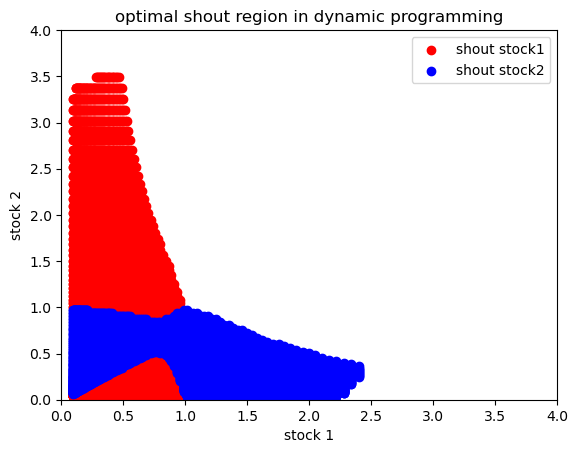

In [114]:
S = compute_S(n, nt, sigma, T)
shout0_x = []
shout0_y = []
shout1_x = []
shout1_y = []
for i in range(nt+1):
    for j in range(nt+1):
        if S[0,i,0]<4 and S[1,0,j]<4:
            if payoff_no_shout_no_shout[i,j] < payoff_no_shout_shout0[i,j] and payoff_no_shout_shout0[i,j] > payoff_no_shout_shout1[i,j]:
                shout0_x.append(S[0,i,0])
                shout0_y.append(S[1,0,j])
            if payoff_no_shout_no_shout[i,j] < payoff_no_shout_shout1[i,j] and payoff_no_shout_shout1[i,j] > payoff_no_shout_shout0[i,j]:
                shout1_x.append(S[0,i,0])
                shout1_y.append(S[1,0,j])
plt.scatter(shout0_x, shout0_y, c="red", label='shout stock1')
plt.scatter(shout1_x, shout1_y, c="blue", label='shout stock2')
plt.title("optimal shout region in dynamic programming")
plt.xlim(0,4)
plt.ylim(0,4)
plt.xlabel("stock 1")
plt.ylabel("stock 2")
plt.legend(loc="upper right")
plt.show()

## American Monte Carlo 

In [75]:
n_e = [7*i for i in range(1, 52)] + [365]
n_e = [180, 365]
num_sim = 100000
Ts = np.array([i*T/365 for i in n_e])
S = simulate_S(Ts, num_sim=num_sim)

# create shout values for uniformly random strategy
Ks = np.zeros((len(n_e), num_sim, 2))
np.random.seed(2023)
for nt in range(1, len(n_e)):
    K0_sel = (Ks[nt-1, :, 0] == 0) & (S[nt-1, :, 0] < K)
    K1_sel = (Ks[nt-1, :, 1] == 0) & (S[nt-1, :, 1] < K)
    K0_only = K0_sel & (~K1_sel)
    K_both = K0_sel & K1_sel
    K1_only = K1_sel & (~K0_sel)

    Ks[nt:, K0_only, 0] = np.where(np.random.choice(2, size=sum(K0_only)) == 0, S[nt-1, K0_only, 0], 0)
    Ks[nt:, K1_only, 1] = np.where(np.random.choice(2, size=sum(K1_only)) == 0, S[nt-1, K1_only, 1], 0)
    action = np.random.choice(3, size=sum(K_both))
    Ks[nt:, K_both, 0] = np.where(action == 0, S[nt-1, K_both, 0], 0)
    Ks[nt:, K_both, 1] = np.where(action == 1, S[nt-1, K_both, 1], 0)

In [79]:
def compute_value(K0e, K1e, S0e, S1e):
    A = 0.5*(S0e+S1e)
    return np.where((K0e>0) & (K1e>0), np.maximum(0, A - 0.5*(K0e+K1e)),
                np.where(K0e>0, np.maximum(0, A - 0.5*(K0e + np.minimum(K, S1e))),
                    np.where(K1e>0, np.maximum(0, A - 0.5*(K1e + np.minimum(K, S0e))),
                        np.where(S1e>S0e, np.maximum(0, A - 0.5*(K + np.minimum(K, S0e))),
                            np.maximum(0, A - 0.5*(K + np.minimum(K, S1e)))))))

def take_action_based_on_model_for_optimal_policy(i, K0e, K1e, S0e, S1e):
    X = np.vstack([K0e, K1e, S0e, S1e]).T
    F = PolynomialFeatures(degree_features).fit_transform(X)

    values = {}
    values["noShout"] = models["noShout"][i].predict(F)
    values["shout0"] = np.where(K0e == 0, models["shout0"][i].predict(F), values["noShout"])
    values["shout1"] = np.where(K1e == 0, models["shout1"][i].predict(F), values["noShout"])

    sel0 = (K0e == 0) & (S0e < K) & (values["shout0"] > values["noShout"]) & ((K1e > 0) | ((K1e == 0) & ((S1e > K) | (values["shout0"]>values["shout1"]))))
    K0e[sel0] = S0e[sel0]
    sel1 = (K1e == 0) & (S1e < K) & (values["shout1"] > values["noShout"]) & ((K0e > 0) | ((K0e == 0) & ((S0e > K) | (values["shout1"]>values["shout0"]))))
    K1e[sel1] = S1e[sel1]

    return K0e, K1e

def q(action, nt):
    if action == 'noShout':
        sel = Ks[nt, :, 0] > -1
        K0_eff = deepcopy(Ks[nt, :, 0])
        K1_eff = deepcopy(Ks[nt, :, 1])
    elif action == 'shout0':
        sel = (Ks[nt, :, 0] == 0) & (S[nt, :, 0] < K)
        K0_eff = deepcopy(S[nt, sel, 0])
        K1_eff = deepcopy(Ks[nt, sel, 1])
    else:
        sel = (Ks[nt, :, 1] == 0) & (S[nt, :, 1] < K)
        K0_eff = deepcopy(Ks[nt, sel, 0])
        K1_eff = deepcopy(S[nt, sel, 1])

    for i in range(nt+1, len(n_e)-1):
        K0_eff, K1_eff = take_action_based_on_model_for_optimal_policy(i, K0_eff, K1_eff, S[i, sel, 0], S[i, sel, 1])

    values = compute_value(K0_eff, K1_eff, S[-1, sel, 0], S[-1, sel, 1])
    X = np.vstack([Ks[nt, sel, 0], Ks[nt, sel, 1], S[nt, sel, 0], S[nt, sel, 1]]).T
    return X, values, sel

In [80]:
# calibrate linear models of q-action value function of optimal policy
nt = len(n_e)-2
degree_features = 2

all_actions = ["noShout", "shout0", "shout1"]
models = {action: [None for _ in range(len(n_e)-1)] for action in all_actions}

for nt in range(len(n_e)-2, -1, -1):
    for action in all_actions:
        X, values, _ = q(action, nt)
        F = PolynomialFeatures(degree_features).fit_transform(X)
        models[action][nt] = LinearRegression().fit(F, values)

In [81]:
# use models of q function of optimal policy to compute the value
K0 = np.zeros(num_sim)
K1 = np.zeros(num_sim)

for nt in range(len(n_e) - 1):
    K0, K1 = optimalPolicy(nt, K0, K1, S[nt, :, 0], S[nt, :, 1])

v = compute_value(K0, K1, S[-1,:,0], S[-1,:,1])
sd = np.std(v)/num_sim**0.5
print(np.mean(v), np.mean(v) - 2*sd, np.mean(v)+2*sd)

0.13082057106113137 0.12968239460228553 0.13195874751997722


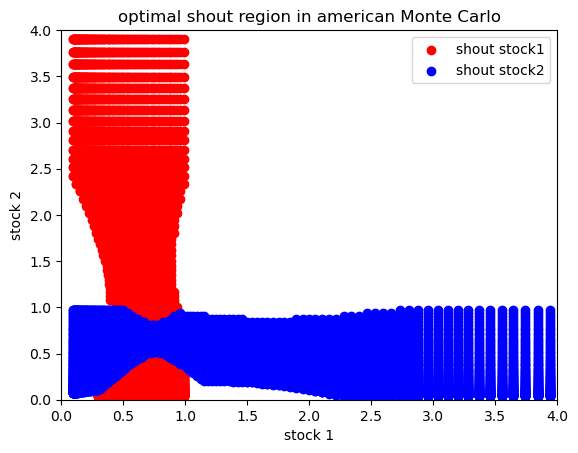

In [95]:
nt = 180
S = compute_S(n, nt, sigma, T)
shout0_x = []
shout0_y = []
shout1_x = []
shout1_y = []
for i in range(nt+1):
    for j in range(nt+1):
        if S[0,i,0]<4 and S[1,0,j]<4:
            F = PolynomialFeatures(degree_features).fit_transform(np.array([[0,0,S[0,i,0], S[1,0,j]]]))
            value_no_shout = models["noShout"][0].predict(F)
            value_shout0 = models["shout0"][0].predict(F)
            value_shout1 = models["shout1"][0].predict(F)
            if value_no_shout < value_shout0 and value_shout0 > value_shout1 and S[0,i,0]<K:
                shout0_x.append(S[0,i,0])
                shout0_y.append(S[1,0,j])
            if value_no_shout < value_shout1 and value_shout1> value_shout0 and S[1,0,j]<K:
                shout1_x.append(S[0,i,0])
                shout1_y.append(S[1,0,j])
plt.scatter(shout0_x, shout0_y, c="red", label='shout stock1')
plt.scatter(shout1_x, shout1_y, c="blue", label='shout stock2')
plt.title("optimal shout region in american Monte Carlo")
plt.xlim(0,4)
plt.ylim(0,4)
plt.xlabel("stock 1")
plt.ylabel("stock 2")
plt.legend(loc="upper right")
plt.show()

## Dynamic Monte Carlo

In [232]:
#n_e = [180, 365]
n_e = [7*i for i in range(1, 52)] + [365]
num_sim = 100000
Ts = np.array([i*T/365 for i in n_e])
S = simulate_S(Ts, num_sim=num_sim)

payoff_no_shout_no_shout = np.maximum(0.5*(S[-1, :, 0]+S[-1, :, 1]) - K, 0)
payoff_no_shout_shout0 = np.maximum(0.5*(S[-1, :, 0]+S[-1, :, 1]) - 0.5*(S[-1,:,0]+K), 0)
payoff_no_shout_shout1 = np.maximum(0.5*(S[-1, :, 0]+S[-1, :, 1]) - 0.5*(S[-1,:,1]+K), 0)
payoff_no_shout = max_vec(payoff_no_shout_no_shout, payoff_no_shout_shout0, payoff_no_shout_shout1)

Km = np.repeat(Kv.reshape(1,-1), num_sim, axis=0)
payoff_shouted_both = max_vec(0, 0.5*(S[-1, :, 0]+S[-1, :, 1]).reshape(-1,1) - Km)

payoff_shouted0_no_shout = max_vec(0, 0.5*(S[-1, :, 0]+S[-1,:,1]).reshape(-1,1) - 0.5*(Km+K))
payoff_shouted0_shout = max_vec(0, 0.5*(S[-1, :, 0]+S[-1,:,1]).reshape(-1,1) - 0.5*(Km+S[-1,:,1].reshape(-1,1)))
payoff_shouted0 = max_vec(payoff_shouted0_no_shout, payoff_shouted0_shout)

payoff_shouted1_no_shout = max_vec(0, 0.5*(S[-1, :, 0]+S[-1,:,1]).reshape(-1,1) - 0.5*(Km+K))
payoff_shouted1_shout = max_vec(0, 0.5*(S[-1, :, 0]+S[-1,:,1]).reshape(-1,1) - 0.5*(Km+S[-1,:,0].reshape(-1,1)))
payoff_shouted1 = max_vec(payoff_shouted1_no_shout, payoff_shouted1_shout)

In [233]:
degree_features = 2

for nt in range(len(n_e)-2, -1, -1):
    # state: no_shout

    ## action: shout 0
    sel0 = S[nt, :, 0] < K
    F = PolynomialFeatures(degree_features).fit_transform(S[nt, sel0, :])
    model_no_shout_no_shout = LinearRegression().fit(F, payoff_no_shout[sel0])

    Kvn_lower_index = (S[nt, sel0, 0] - Kv0) // Kv_step
    Kvn_lower_index = (np.maximum(0, np.minimum(Kvn_lower_index, Kv_num-2))).astype(int)
    Kvn_lower_weight = 1.0 - (S[nt, sel0, 0] - (Kv0 + Kvn_lower_index * Kv_step)) / Kv_step
    Kvn_lower_weight = np.minimum(1.0, np.maximum(0.0, Kvn_lower_weight))
    payoff_shouted0_sel0 = payoff_shouted0[sel0, :]
    j = np.ogrid[:payoff_shouted0_sel0.shape[0]]
    payoff_no_shout_shout0 = Kvn_lower_weight * payoff_shouted0_sel0[j, Kvn_lower_index] +\
        (1-Kvn_lower_weight) * payoff_shouted0_sel0[j, 1+Kvn_lower_index]
    model_no_shout_shout0 = LinearRegression().fit(F, payoff_no_shout_shout0)

    sel00 = model_no_shout_shout0.predict(F) > model_no_shout_no_shout.predict(F)
    if not plot_exercise_region:
        payoff_no_shout[sel0] = np.where(sel00, payoff_no_shout_shout0, payoff_no_shout[sel0])

    ## action: shout1
    sel1 = S[nt, :, 1] < K
    F2 = PolynomialFeatures(degree_features).fit_transform(S[nt, sel1, :])
    model_no_shout_no_shout = LinearRegression().fit(F2, payoff_no_shout[sel1])

    Kvn_lower_index = (S[nt, sel1, 1] - Kv0) // Kv_step
    Kvn_lower_index = (np.maximum(0, np.minimum(Kvn_lower_index, Kv_num-2))).astype(int)
    Kvn_lower_weight = 1.0 - (S[nt, sel1, 1] - (Kv0 + Kvn_lower_index * Kv_step)) / Kv_step
    Kvn_lower_weight = np.minimum(1.0, np.maximum(0.0, Kvn_lower_weight))
    payoff_shouted1_sel1 = payoff_shouted1[sel1, :]
    j = np.ogrid[:payoff_shouted1_sel1.shape[0]]
    payoff_no_shout_shout1 = Kvn_lower_weight * payoff_shouted1_sel1[j, Kvn_lower_index] +\
        (1-Kvn_lower_weight) * payoff_shouted1_sel1[j, 1+Kvn_lower_index]
    model_no_shout_shout1 = LinearRegression().fit(F2, payoff_no_shout_shout1)

    sel11 = model_no_shout_shout1.predict(F2) > model_no_shout_no_shout.predict(F2)
    if plot_exercise_region:
        break
    payoff_no_shout[sel1] = np.where(sel11, payoff_no_shout_shout1, payoff_no_shout[sel1])
    
    # state: shouted0
    sel1 = S[nt, :, 1] < K
    F = PolynomialFeatures(degree_features).fit_transform(S[nt, sel1, :])

    Kmn = 0.5*(S[nt, sel1, 1].reshape(-1,1) + Km[sel1])
    Kmn_lower_index = (Kmn - Kv0) // Kv_step
    Kmn_lower_index = (np.maximum(0, np.minimum(Kmn_lower_index, Kv_num-2))).astype(int)
    Kmn_lower_weight = 1.0 - (Kmn - (Kv0 + Kmn_lower_index * Kv_step)) / Kv_step
    Kmn_lower_weight = np.minimum(1.0, np.maximum(0.0, Kmn_lower_weight))
    payoff_shouted_both_sel1 = payoff_shouted_both[sel1, :]
    j = np.array([[i] for i in range(payoff_shouted_both_sel1.shape[0])])
    payoff_shouted0_shout1 = Kmn_lower_weight * payoff_shouted_both_sel1[j, Kmn_lower_index] +\
        (1.0 - Kmn_lower_weight) * payoff_shouted_both_sel1[j, 1+Kmn_lower_index]

    for i in range(Kv_num):
        model_shouted0_no_shout = LinearRegression().fit(F, payoff_shouted0[sel1, i])
        model_shouted0_shout1 = LinearRegression().fit(F, payoff_shouted0_shout1[:, i])
        sel11 = model_shouted0_shout1.predict(F) > model_shouted0_no_shout.predict(F)
        payoff_shouted0[sel1, i] = np.where(sel11, payoff_shouted0_shout1[:, i], payoff_shouted0[sel1, i])

    ## state: shouted1
    sel0 = S[nt, :, 0] < K
    F = PolynomialFeatures(degree_features).fit_transform(S[nt, sel0, :])

    Kmn = 0.5*(S[nt, sel0, 0].reshape(-1,1) + Km[sel0])
    Kmn_lower_index = (Kmn - Kv0) // Kv_step
    Kmn_lower_index = (np.maximum(0, np.minimum(Kmn_lower_index, Kv_num-2))).astype(int)
    Kmn_lower_weight = 1.0 - (Kmn - (Kv0 + Kmn_lower_index * Kv_step)) / Kv_step
    Kmn_lower_weight = np.minimum(1.0, np.maximum(0.0, Kmn_lower_weight))
    payoff_shouted_both_sel0 = payoff_shouted_both[sel0, :]
    j = np.array([[i] for i in range(payoff_shouted_both_sel0.shape[0])])
    payoff_shouted1_shout0 = Kmn_lower_weight * payoff_shouted_both_sel0[j, Kmn_lower_index] +\
        (1.0 - Kmn_lower_weight) * payoff_shouted_both_sel0[j, 1+Kmn_lower_index]

    for i in range(Kv_num):
        model_shouted1_no_shout = LinearRegression().fit(F, payoff_shouted1[sel0, i])
        model_shouted1_shout0 = LinearRegression().fit(F, payoff_shouted1_shout0[:, i])
        sel00 = model_shouted1_shout0.predict(F) > model_shouted1_no_shout.predict(F)
        payoff_shouted1[sel0, i] = np.where(sel00, payoff_shouted1_shout0[:, i], payoff_shouted1[sel0, i])

    #print(nt)

print(np.mean(payoff_no_shout))
sd = np.std(payoff_no_shout)/num_sim**0.5
print(np.mean(payoff_no_shout) - 2*sd, np.mean(payoff_no_shout)+2*sd)
e = (num_sim, np.mean(payoff_no_shout), np.mean(payoff_no_shout) - 2*sd, np.mean(payoff_no_shout)+2*sd)


50
49
48
47
46
45
44
43
42
41
40
39
38
37
36
35
34
33
32
31
30
29
28
27
26
25
24
23
22
21
20
19
18
17
16
15
14
13
12
11
10
9
8
7
6
5
4
3
2
1
0
0.14109826001426795
0.13994265436875866 0.14225386565977724


## LSMC and LSFQI

In [64]:
def state_to_feat(state):
    S1, S2, aveK, ass, time = state
    if time == 0 or ass == 0:
        return np.array([1,S1,S2,S1**2,S1*S2,S2**2])
    return np.array([1,S1,S2,aveK,S1**2,S1*S2,S1*aveK,S2**2,S2*aveK, aveK**2])


def state_to_afterState(state, a):
    oldK = state[2]
    if a == 0:
        newK = oldK
        newShoutState = state[3]
    else:
        if oldK == 0:
            newK = state[int(a-1)]
            newShoutState = a # shout state 1 means shouted0 and shout state 2 means shouted1
        else:
            newK = 0.5*(oldK + state[int(a-1)])
            newShoutState = 3
    afterState = np.array([state[0], state[1], newK, newShoutState, state[4]])
    return afterState


def possible_actions(state):
    r = [0]
    if state[3] in [0, 2] and state[0] < K:
        r.append(1)
    if state[3] in [0, 1] and state[1] < K:
        r.append(2)
    return r


def compute_gain_for_policy(S, w, epsilon):
    n_t, num_sim = S.shape[:2]
    
    states = np.zeros((n_t, num_sim, 5))
    states[:, :, :2] = S
    for i in range(n_t):
        states[i, :, 4] = i
    actions = np.zeros((n_t, num_sim))
    
    for i in range(n_t-1):
        for j in range(num_sim):
            bestQ = -np.infty
            all_possible_actions = possible_actions(states[i, j])
            if np.random.uniform() < epsilon:
                random_action = np.random.choice(all_possible_actions)
                all_possible_actions = [random_action]
            for a in all_possible_actions:
                afterState = state_to_afterState(states[i, j], a)
                afterFeat = state_to_feat(afterState)
                q = np.dot(afterFeat, w[(i, afterState[3])])
                if q > bestQ:
                    bestQ = q
                    bestAction = a
                    bestAfterState = afterState
            states[i+1, j, 2:4] = bestAfterState[2:4]
            actions[i, j] = bestAction

    average = 0.5 * (states[-1, :, 0] + states[-1, :, 1])
    gains = np.where(states[-1, :, 3] == 0, np.maximum(0.0, average - 0.5*(K + np.minimum(K,np.minimum(states[-1, :, 0], states[-1, :, 1])))),
                 np.where(states[-1, :, 3] == 3, np.maximum(0.0, average - states[-1, :, 2]),
                     np.where(states[-1, :, 3] == 2, np.maximum(0.0, average - 0.5*(np.minimum(K,states[-1, :, 0])+states[-1, :, 2])),
                        np.maximum(0.0, average - 0.5*(np.minimum(K,states[-1, :, 1])+states[-1, :, 2])))))
    return gains, states, actions
        

def compute_target_fqi(i, j):
    state_next = list(states[i+1, j, :2]) + list(afterState[2:4]) + [i+1]
    q_next = -np.infty
    if i+1 == len(n_e)-1:
        ave = 0.5*np.sum(S[i+1,j])
        if state_next[3] == 0:
            q_next = max(0, ave - 0.5*(K+min(K, S[i+1,j,0], S[i+1,j,1])))
        elif state_next[3] == 3:
            q_next = max(0, ave - 0.5*state_next[2])
        elif state_next[3] == 1:
            q_next = max(0, ave - 0.5*(state_next[2]+min(K,S[i+1,j,1])))
        elif state_next[3] == 2:
            q_next = max(0, ave - 0.5*(state_next[2]+min(K,S[i+1,j,0])))
    else:
        all_possible_actions = possible_actions(state_next)
        for a in all_possible_actions:
            afterState_next = state_to_afterState(state_next, a)
            afterFeat_next = state_to_feat(afterState_next)
            q_next = max(q_next, np.dot(afterFeat_next, w[(i+1, afterState_next[3])]))
    return q_next

    
n_e = [7*i for i in range(1, 52)] + [365]
n_e = [90, 180, 270, 365]
num_sim = 100000
Ts = np.array([i*T/365 for i in n_e])
S = simulate_S(Ts, num_sim=num_sim)

algo = "LSMC" # LSMC or LSFQI
num_policy_steps = 5

num_feat0 = 6 # 1, S1, S2, S1**2, S2**2, S1 * S2
num_feat = 10 # 1, S1, S2, K, S1**2, S1 * S2, S1 * K, S2**2, ..
w0 = {(0, ass): np.zeros(num_feat0) for ass in range(3)}
w1 = {(i, ass): np.zeros(num_feat0 if ass == 0 else num_feat) for i in range(1, len(n_e)-1) for ass in range(4)}
w = {**w0, **w1}


for nsp in range(num_policy_steps):
    G, states, actions = compute_gain_for_policy(S, w, 1/(1+nsp))
    
    A = {}
    b = {}
    for i in range(len(n_e)-1):
        for j in range(num_sim):
            afterState = state_to_afterState(states[i, j], actions[i, j])
            afterFeat = state_to_feat(afterState)

            target = G[j] if algo == "LSMC" else compute_target_fqi(i, j)

            A[(i, afterState[3])] = A.get((i, afterState[3]), 0) + np.outer(afterFeat, afterFeat)
            b[(i, afterState[3])] = b.get((i, afterState[3]), 0) + afterFeat*target
            
    for k in A:
        try:
            w[k] = np.matmul(np.linalg.inv(A[k]), b[k])
        except np.linalg.LinAlgError:
            pass

    G, _, _ = compute_gain_for_policy(S, w, 0)
    sd = np.std(G) / num_sim**0.5
    print(nsp, np.mean(G), np.mean(G)-2*sd, np.mean(G)+2*sd)


0 0.13715433985222733 0.13599758825699157 0.1383110914474631
1 0.1373386641575093 0.13617821797673546 0.13849911033828316
2 0.13739816697907936 0.13623750492407227 0.13855882903408645
3 0.13724109512691074 0.13607928205481282 0.13840290819900866
4 0.13734110800967342 0.13618109004596066 0.13850112597338618
104.29320049285889


In [1]:
from keras import backend as K
import keras

In [2]:
LEARNING_RATE = 0.0001

class Brain:
    def __init__(self, dim_state_space, architecture):
        self.dim_state_space = dim_state_space
        self.architecture = architecture

        self.model = self._createModel()
        self.model_target = self._createModel() 

    def _createModel(self):
        model = Sequential()

        model.add(Dense(units=architecture[0], activation='relu', input_dim=dim_state_space))
        for units_in_layer in architecture[1:]:
            model.add(Dense(units=units_in_layer, activation='relu'))
        model.add(Dense(units=1, activation='linear'))

        opt = RMSprop(lr=LEARNING_RATE)
        model.compile(loss=keras.losses.huber, optimizer=opt)

        return model

    def train(self, x, y, epochs=1, verbose=0):
        self.model.fit(x, y, batch_size=x.shape[0], epochs=epochs, verbose=verbose)

    def predict(self, s, target=False):
        if target:
            return self.model_target.predict(s)
        else:
            return self.model.predict(s)

    def updateTargetModel(self):
        self.model_.set_weights(self.model.get_weights())

In [3]:
class Memory:   # stored as ( after_state, r, next (S1,S2) )
    samples = []

    def __init__(self, capacity):
        self.capacity = capacity

    def add(self, sample):
        self.samples.append(sample)        

        if len(self.samples) > self.capacity:
            self.samples.pop(0)

    def sample(self, n):
        n = min(n, len(self.samples))
        return random.sample(self.samples, n)

    def isFull(self):
        return len(self.samples) >= self.capacity

In [7]:
class Agent:
    steps = 0
    epsilon = MAX_EPSILON

    def __init__(self, stateCnt, actionCnt):
        self.stateCnt = stateCnt
        self.actionCnt = actionCnt

        self.brain = Brain(stateCnt, actionCnt)
        self.memory = Memory(MEMORY_CAPACITY)
        
    def act(self, s):
        if random.random() < self.epsilon:
            return random.randint(0, self.actionCnt-1)
        else:
            return numpy.argmax(self.brain.predictOne(s))

    def observe(self, sample):  # in (s, a, r, s_) format
        self.memory.add(sample)        

        if self.steps % UPDATE_TARGET_FREQUENCY == 0:
            self.brain.updateTargetModel()

     # slowly decrease Epsilon based on our eperience
        self.steps += 1
        self.epsilon = MIN_EPSILON + (MAX_EPSILON - MIN_EPSILON) * math.exp(-LAMBDA * self.steps)

    def replay(self):    
        batch = self.memory.sample(BATCH_SIZE)
        batchLen = len(batch)

        no_state = numpy.zeros(self.stateCnt)

        states = numpy.array([ o[0] for o in batch ])
        states_ = numpy.array([ (no_state if o[3] is None else o[3]) for o in batch ])

        p = self.brain.predict(states)
        p_ = self.brain.predict(states_, target=True)

        x = numpy.zeros((batchLen, self.stateCnt))
        y = numpy.zeros((batchLen, self.actionCnt))
        
        for i in range(batchLen):
            o = batch[i]
            s = o[0]; a = o[1]; r = o[2]; s_ = o[3]

            t = p[i]
            if s_ is None:
                t[a] = r
            else:
                t[a] = r + GAMMA * numpy.amax(p_[i])

            x[i] = s
            y[i] = t

        self.brain.train(x, y)

NameError: name 'MAX_EPSILON' is not defined

In [ ]:
class Environment:
    def __init__(self, problem):
        self.problem = problem
        self.env = gym.make(problem)

    def run(self, agent):
        s = self.env.reset()
        R = 0 

        while True:            
            # self.env.render()

            a = agent.act(s)

            s_, r, done, info = self.env.step(a)

            if done: # terminal state
                s_ = None

            agent.observe( (s, a, r, s_) )
            agent.replay()            

            s = s_
            R += r

            if done:
                break

        # print("Total reward:", R)

In [ ]:
n_e = [90, 180, 270, 365]
num_sim = 2**14
Ts = np.array([i*T/365 for i in n_e])
S = simulate_S(Ts, num_sim=num_sim)
S_transposed = np.transpose(S, (1, 0, 2))

num_episodes_in_mini_batch = 2**6
size_mini_batch = num_episodes_in_mini_batch * (len(n_e)-1)
num_mini_batches = num_sim // num_episodes_in_mini_batch
epsilon = 0.1

In [ ]:
num_episodes = 2

MEMORY = memory(1000000)

def state_to_afterState(state, a):
    oldK = state[2]
    if a == 0:
        newK = oldK
        newShoutState = state[3]
    else:
        if oldK == 0:
            newK = state[int(a-1)]
            newShoutState = a # shout state 1 means shouted0 and shout state 2 means shouted1
        else:
            newK = 0.5*(oldK + state[int(a-1)])
            newShoutState = 3
    afterState = np.array([state[0], state[1], newK, newShoutState, state[4]])
    return afterState


def final_payoff(i, K_past, shout_state):
    ave = 0.5 * (S[-1, i, 0] + S[-1, i, 1])
    if shout_state = 3:
        return max(0, ave - K_past)
    elif shout_state = 2:
        return max(0, ave - 0.5*(min(K, S[-1, i, 0]) + K_past)))
    elif shout_state = 1:
        return max(0, ave - 0.5*(min(K, S[-1, i, 1]) + K_past)))
    else:
        return max(0, ave - min(K, 0.5 * (K + min(S[-1, i, 0], S[-1, i, 1]))))


def update_policy():
    batch = MEMORY.sample(BATCH_SIZE)
    batchLen = len(batch)

    no_state = numpy.zeros(self.stateCnt)

    states = numpy.array([ o[0] for o in batch ])
    states_ = numpy.array([ (no_state if o[3] is None else o[3]) for o in batch ])

    p = self.brain.predict(states)
    p_ = self.brain.predict(states_, target=True)

    x = numpy.zeros((batchLen, self.stateCnt))
    y = numpy.zeros((batchLen, self.actionCnt))
    
    for i in range(batchLen):
        o = batch[i]
        s = o[0]; a = o[1]; r = o[2]; s_ = o[3]

        t = p[i]
        if s_ is None:
            t[a] = r
        else:
            t[a] = r + GAMMA * numpy.amax(p_[i])

        x[i] = s
        y[i] = t

    self.brain.train(x, y)


def simulate_batch(S, i_start, i_end, epsilon=0):
    res = []
    for i in range(i_start, i_end):
        shout_state = 0
        K_past = 0
        for j in range(len(n_e)-1):
            all_possible_actions = possible_actions(S[j, i, 0], S[j, i, 1], shout_state, epsilon)
            best_q = -np.infty
            for a in possible_actions:
                after_state = state_to_afterState(S[j, i, 0], S[j, i, 1], K_past, shout_state, j)
                q = brain.predict(after_state, target=False)
                if q > best_q:
                    best_q = q
                    best_after_state = after_state
            K_past, shout_state = after_state[2:4]
            r = 0 if j < len(n_e)-1 else final_payoff(i, K_past, shout_state)
            MEMORY.add((after_state, r, (S[j+1, i, 0], S[j+1, i, 1]))
                    
                
brain = ()
for i in range(num_episodes):
    S_transpose_shuffled = np.random.shuffle(S_transpose)
    S_shuffled = np.transpose(S_transpose_shuffled, (1, 0, 2))
    for j in range(num_mini_batches):
        obs = simulate_batch(S_shuffled, j * size_mini_batch, (j + 1) * size_mini_batch, epsilon)
        update_policy()
    update_target_model()

In [7]:
2**4//2**2

4

In [ ]:
class Brain:
    def __init__(self, dim_state_space, architecture):
        self.dim_state_space = dim_state_space
        self.architecture = architecture

        self.model = self._createModel()
        self.model_target = self._createModel() 

    def _createModel(self):
        model = Sequential()

        model.add(Dense(units=architecture[0], activation='relu', input_dim=dim_state_space))
        for units_in_layer in architecture[1:]:
            model.add(Dense(units=units_in_layer, activation='relu'))
        model.add(Dense(units=1, activation='linear'))

        opt = RMSprop(lr=LEARNING_RATE)
        model.compile(loss=keras.losses.huber, optimizer=opt)

        return model

    def train(self, x, y, epochs=1, verbose=0):
        self.model.fit(x, y, batch_size=x.shape[0], epochs=epochs, verbose=verbose)

    def predict(self, s, target=False):
        if target:
            return self.model_target.predict(s)
        else:
            return self.model.predict(s)

    def updateTargetModel(self):
        self.model_.set_weights(self.model.get_weights())
        

class Memory:
    samples = []

    def __init__(self, capacity):
        self.capacity = capacity

    def add(self, sample):
        self.samples.append(sample)        

        if len(self.samples) > self.capacity:
            self.samples.pop(0)

    def sample(self, n):
        n = min(n, len(self.samples))
        return random.sample(self.samples, n)

    def isFull(self):
        return len(self.samples) >= self.capacity

In [ ]:
class Agent:
    steps = 0
    epsilon = MAX_EPSILON

    def __init__(self, dim_after_state, architecture):
        self.dim_after_state = dim_after_state

        self.brain = Brain(dim_after_state, architecture)
        self.memory = Memory(MEMORY_CAPACITY)

    def possible_actions(state, epsilon):
        S0, S1, _, shout_state, _ = state
        r = [0]
        if shout_state in [0, 2] and S0 < K:
            r.append(1)
        if shout_state in [0, 1] and S1 < K:
            r.append(2)
        if np.random.uniform() < epsilon:
            random_action = np.random.choice(r)
            return [random_action]
        else:
            return r
        
    def act(self, s, act_non_randomly):
        eff_epsilon = 0 if act_non_randomly else self.epsilon
        all_possible_actions = possible_actions(s, eff_epsilon)
        best_q = -np.infty
        for a in all_possible_actions:
            after_state = state_to_afterState(s, a)
            q = brain.predict(after_state, target=False)
            if q > best_q:
                best_q = q
                best_action = a
        return a

    def observe(self, sample):  # in (s, a, r, s_) format
        self.memory.add(sample)        

        if self.steps % UPDATE_TARGET_FREQUENCY == 0:
            self.brain.updateTargetModel()

        # slowly decrease Epsilon based on our eperience
        self.steps += 1
        self.epsilon = MIN_EPSILON + (MAX_EPSILON - MIN_EPSILON) * math.exp(-LAMBDA * self.steps)

    def replay(self):    
        batch = self.memory.sample(BATCH_SIZE)
        batchLen = len(batch)

        no_state = numpy.zeros(self.stateCnt)

        states = numpy.array([ o[0] for o in batch ])
        states_ = numpy.array([ (no_state if o[3] is None else o[3]) for o in batch ])

        p = self.brain.predict(states)
        p_ = self.brain.predict(states_, target=True)

        x = numpy.zeros((batchLen, self.stateCnt))
        y = numpy.zeros((batchLen, self.actionCnt))
        
        for i in range(batchLen):
            o = batch[i]
            s = o[0]; a = o[1]; r = o[2]; s_ = o[3]
            
            t = p[i]
            if s_ is None:
                t[a] = r
            else:
                t[a] = r + GAMMA * numpy.amax(p_[i])

            x[i] = s
            y[i] = t

        self.brain.train(x, y)

In [ ]:
class ShoutOptionEnvironment:
    def __init__(self, n_e, num_sim, K=1):
        self.n_e = n_e
        self.num_sim = num_sim
        self.Ts = np.array([i*T/365 for i in n_e])
        S = simulate_S(self.Ts, num_sim=num_sim)
        self.S_transposed = np.transpose(S, (1, 0, 2))
        self.K = K

    def reset(self):
        self.i_sim = 0
        self.i_time = 0
        self.K_shout = 0
        self.shout_state = 0
        S_transposed_shuffled = np.shuffle(self.S_transposed)
        self.S_shuffled = np.transpose(S_transposed_shuffled, (1, 0, 2))
        return (self.S_shuffled[self.i_time, self.i_sim, 0], self.S_shuffled[self.i_time, self.i_sim, 1], 0.0, 0), 0

    def _to_afterState(self, a):
        if a == 0:
            newK = self.K_shout
            newShoutState = self.shout_state
        else:
            S_used = self.S_shuffled[self.t_time, self.i_sim, int(a-1)]
            if self.K_shout == 0:
                newK = S_used
                newShoutState = a
            else:
                newK = 0.5*(self.K_shout + S_used)
                newShoutState = 3
        afterState = np.array([self.S_shuffled[self.t_time, self.i_sim, 0],
                               self.S_shuffled[self.t_time, self.i_sim, 1],
                               newK,
                               newShoutState,
                               T - self.Ts[self.i_time]])
        return afterState
    
    def step(self, action):
        self.K_shout, self.shout_state = self._to_after_state(action)[2:4]
        self.i_time += 1
        r = 0
        new_round = False
        if self.i_time == len(self.n_e)-1:
            S0, S1 = self.S_shuffled[self.t_time, self.i_sim]
            ave = 0.5 * (S0+S1)
            if self.shout_state == 3:
                r = max(0, ave - self.K)
            elif self.shout_state == 2:
                r = max(0, ave - 0.5*(min(S0, self.K) + self.K_shout))
            elif self.shout_state == 1:
                r = max(0, ave - 0.5*(min(S1, self.K) + self.K_shout))
            else:
                r = max(0, ave - 0.5*(min(S1, S0, self.K) + self.K))
            if self.i_sim == self.num_sim-1:
                self.reset()
                new_round = True
            else:
                self.i_sim +=1
                self.i_time = 0
                self.K = 0
                self.shout_state = 0
        return after_state, next_state, r, new_round
        
    def run(self, agent, num_train_rounds):
        state, round = self.reset()

        R = 0
        while round < num_train_rounds+1:
            act_non_randomly = num_train_rounds == 0
            a = agent.act(s, act_non_randomly)

            after_state, next_state, r, new_round = self.step(a)

            if new_round:
                round +=1

            agent.observe( (after_state, r, next_state) )
            agent.replay()

            state = next_state
            R += r

        print(R / (self.num_sim * (num_rounds+1))


In [ ]:
n_e = [90, 180, 270, 365]
num_sim = 2**14
# Ts = np.array([i*T/365 for i in n_e])
# S = simulate_S(Ts, num_sim=num_sim)
# S_transposed = np.transpose(S, (1, 0, 2))

# num_episodes_in_mini_batch = 2**6
# size_mini_batch = num_episodes_in_mini_batch * (len(n_e)-1)
# num_mini_batches = num_sim // num_episodes_in_mini_batch
# epsilon = 0.1
MEMORY_CAPACITY = 100000
MAX_EPSILON = 1.0
LEARNING_RATE = 0.0001


env = ShoutOptionEnvironment(n_e, num_sim, K=1)
# after_state = s1, s2, k_past, shout_state, t_rem
agent = Agent(dim_after_state=5, architecture=(128,64)

In [183]:
n_e = [7*i for i in range(1, 52)] + [365]
#n_e = [180, 365]
num_sim = 100000
Ts = np.array([i*T/365 for i in n_e])
S = simulate_S(Ts, num_sim=num_sim)

# create shout values for uniformly random strategy
Ks = np.zeros((len(n_e), num_sim, 2))
np.random.seed(2023)
for nt in range(1, len(n_e)):
    K0_sel = (Ks[nt-1, :, 0] == 0) & (S[nt-1, :, 0] < K)
    K1_sel = (Ks[nt-1, :, 1] == 0) & (S[nt-1, :, 1] < K)
    K0_only = K0_sel & (~K1_sel)
    K_both = K0_sel & K1_sel
    K1_only = K1_sel & (~K0_sel)

    Ks[nt:, K0_only, 0] = np.where(np.random.choice(2, size=sum(K0_only)) == 0, S[nt-1, K0_only, 0], 0)
    Ks[nt:, K1_only, 1] = np.where(np.random.choice(2, size=sum(K1_only)) == 0, S[nt-1, K1_only, 1], 0)
    action = np.random.choice(3, size=sum(K_both))
    Ks[nt:, K_both, 0] = np.where(action == 0, S[nt-1, K_both, 0], 0)
    Ks[nt:, K_both, 1] = np.where(action == 1, S[nt-1, K_both, 1], 0)

In [184]:
def compute_value(K0e, K1e, S0e, S1e):
    A = 0.5*(S0e+S1e)
    return np.where((K0e>0) & (K1e>0), np.maximum(0, A - 0.5*(K0e+K1e)),
                np.where(K0e>0, np.maximum(0, A - 0.5*(K0e + np.minimum(K, S1e))),
                    np.where(K1e>0, np.maximum(0, A - 0.5*(K1e + np.minimum(K, S0e))),
                        np.where(S1e>S0e, np.maximum(0, A - 0.5*(K + np.minimum(K, S0e))),
                            np.maximum(0, A - 0.5*(K + np.minimum(K, S1e)))))))


def take_action_based_on_model(i, K0e, K1e, S0e, S1e):
    sel0 = K0e == 0
    sel1 = K1e == 0
    sel_nothingShouted = sel0 & sel1
    sel_onlyShouted0 = sel1 & (~sel0)
    sel_onlyShouted1 = sel0 & (~sel1)
    sel_bothShouted = (~sel0) & (~sel1)

    X1 = np.vstack([K0e, K1e, S0e, S1e]).T
    F1 = PolynomialFeatures(degree_features).fit_transform(X1)
    X2 = np.vstack([K1e, S0e, S1e]).T
    F2= PolynomialFeatures(degree_features).fit_transform(X2)
    X3 = np.vstack([K0e, S0e, S1e]).T
    F3 = PolynomialFeatures(degree_features).fit_transform(X3)
    X4 = np.vstack([S0e, S1e]).T
    F4 = PolynomialFeatures(degree_features).fit_transform(X4)

    values = {}
    values["noShout"] = np.where(sel_bothShouted, models[("noShout", "bothShouted", i)].predict(F1),
                                 np.where(sel_onlyShouted0, models[("noShout", "onlyShouted0", i)].predict(F3),
                                          np.where(sel_onlyShouted1, models[("noShout", "onlyShouted1", i)].predict(F2),
                                                   models[("noShout", "nothingShouted", i)].predict(F4))))
    values["shout0"] = np.where(sel_onlyShouted1, models[("shout0", "onlyShouted1", i)].predict(F2),
                                np.where(sel_nothingShouted, models[("shout0", "nothingShouted", i)].predict(F4), values["noShout"]))
    values["shout1"] = np.where(sel_onlyShouted0, models[("shout1", "onlyShouted0", i)].predict(F3),
                                np.where(sel_nothingShouted, models[("shout1", "nothingShouted", i)].predict(F4), values["noShout"]))

    sel00 = (S0e < K) & ((sel_nothingShouted & (values["shout0"] > values["noShout"]) & (values["shout0"]>values["shout1"])) |
                         (sel_onlyShouted1 & (values["shout0"]>values["noShout"])) )
    K0e[sel00] = S0e[sel00]
    sel11 = (S1e < K) & ((sel_nothingShouted & (values["shout1"] > values["noShout"]) & (values["shout1"]>values["shout0"])) |
                         (sel_onlyShouted0 & (values["shout1"]>values["noShout"])) )
    K1e[sel11] = S1e[sel11]
    return K0e, K1e


def q(action, nt):
    if action == 'noShout':
        sel = Ks[nt, :, 0] > -1
        K0_eff = deepcopy(Ks[nt, :, 0])
        K1_eff = deepcopy(Ks[nt, :, 1])
    elif action == 'shout0':
        sel = (Ks[nt, :, 0] == 0) & (S[nt, :, 0] < K)
        K0_eff = deepcopy(S[nt, sel, 0])
        K1_eff = deepcopy(Ks[nt, sel, 1])
    else:
        sel = (Ks[nt, :, 1] == 0) & (S[nt, :, 1] < K)
        K0_eff = deepcopy(Ks[nt, sel, 0])
        K1_eff = deepcopy(S[nt, sel, 1])

    for i in range(nt+1, len(n_e)-1):
        K0_eff, K1_eff = take_action_based_on_model(i, K0_eff, K1_eff, S[i, sel, 0], S[i, sel, 1])

    values = compute_value(K0_eff, K1_eff, S[-1, sel, 0], S[-1, sel, 1])
    X = np.vstack([Ks[nt, sel, 0], Ks[nt, sel, 1], S[nt, sel, 0], S[nt, sel, 1]]).T
    return X, values, sel

In [185]:
# calibrate linear models to q-action value function of optimal policy
nt = len(n_e)-2
degree_features = 2

class default_model:
    def predict(self, F):
        return -1e10
dm = default_model()

all_states = ['bothShouted', 'nothingShouted', 'onlyShouted0', 'onlyShouted1']
all_actions = ["noShout", "shout0", "shout1"]
models = {(a, s, t): dm for a in all_actions for s in all_states for t in range(len(n_e)-2, -1, -1)}

for nt in range(len(n_e)-2, -1, -1):
    for action in all_actions:
        X, values, sel = q(action, nt)
        sel0 = Ks[nt, sel, 0] == 0
        sel1 = Ks[nt, sel, 1] == 0
        sel_nothingShouted = sel0 & sel1
        sel_onlyShouted0 = sel1 & (~sel0)
        sel_onlyShouted1 = sel0 & (~sel1)
        sel_bothShouted = (~sel0) & (~sel1)
        
        if action == "noShout":
            if sum(sel_bothShouted)>10:
                F = PolynomialFeatures(degree_features).fit_transform(X[sel_bothShouted])
                models[('noShout', 'bothShouted', nt)] = LinearRegression().fit(F, values[sel_bothShouted])
            if sum(sel_onlyShouted1)>10:
                F = PolynomialFeatures(degree_features).fit_transform(X[sel_onlyShouted1, 1:])
                models[('noShout', 'onlyShouted1', nt)] = LinearRegression().fit(F, values[sel_onlyShouted1])
            if sum(sel_onlyShouted0)>10:
                F = PolynomialFeatures(degree_features).fit_transform(X[:, [0,2,3]][sel_onlyShouted0])
                models[('noShout', 'onlyShouted0', nt)] = LinearRegression().fit(F, values[sel_onlyShouted0])
            if sum(sel_nothingShouted)>10:
                F = PolynomialFeatures(degree_features).fit_transform(X[sel_nothingShouted, 2:])
                models[('noShout', 'nothingShouted', nt)] = LinearRegression().fit(F, values[sel_nothingShouted])
        elif action == "shout0":
            if sum(sel_onlyShouted1)>10:
                F = PolynomialFeatures(degree_features).fit_transform(X[sel_onlyShouted1, 1:])
                models[('shout0', 'onlyShouted1', nt)] = LinearRegression().fit(F, values[sel_onlyShouted1])
            if sum(sel_nothingShouted)>10:
                F = PolynomialFeatures(degree_features).fit_transform(X[sel_nothingShouted, 2:])
                models[('shout0', 'nothingShouted', nt)] = LinearRegression().fit(F, values[sel_nothingShouted])
        elif action == "shout1":
            if sum(sel_onlyShouted0)>10:
                F = PolynomialFeatures(degree_features).fit_transform(X[:, [0,2,3]][sel_onlyShouted0])
                models[('shout1', 'onlyShouted0', nt)] = LinearRegression().fit(F, values[sel_onlyShouted0])
            if sum(sel_nothingShouted)>10:
                F = PolynomialFeatures(degree_features).fit_transform(X[sel_nothingShouted, 2:])
                models[('shout1', 'nothingShouted', nt)] = LinearRegression().fit(F, values[sel_nothingShouted])



In [186]:
# use models of q function of optimal policy to compute the value
S = simulate_S(Ts, num_sim=num_sim, seed=2025)

K0 = np.zeros(num_sim)
K1 = np.zeros(num_sim)

for nt in range(len(n_e) - 1):
    K0, K1 = take_action_based_on_model(nt, K0, K1, S[nt, :, 0], S[nt, :, 1])

v = compute_value(K0, K1, S[-1,:,0], S[-1,:,1])
sd = np.std(v)/num_sim**0.5
print(np.mean(v), np.mean(v) - 2*sd, np.mean(v)+2*sd)

0.1292858395927054 0.1280939961646941 0.1304776830207167


In [187]:
5**4

625